# Build and train MB-SupCon

* Refer to CMC: https://github.com/HobbitLong/CMC/blob/master/train_CMC.py
* Refer to SupContrast: https://github.com/HobbitLong/SupContrast

In [1]:
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import pandas as pd
import re
import sys

from scipy.stats import spearmanr
#import skimage

import time
import torch
import torch.hub
import torch.nn

import random

# Self-defined functions
from MB_SupCon_utils import Dataset
from MB_SupCon_utils import Encoder

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"  ###### "cuda: 1"
else:
    device = "cpu"

## 1 Load data

In [24]:
gut_16s_df = pd.read_table("./data/gut_16s_abundance.txt", index_col=0)
metabolome_df = pd.read_table("./data/metabolome_abundance.txt", index_col=0)
metabolome_df = metabolome_df.drop(columns=['SubjectID', 'CollectionDate', 'CL1', 'CL2', 'CL3', 'CL4'])

In [4]:
from sklearn.preprocessing import StandardScaler
gut_16s_df_array = StandardScaler().fit_transform(gut_16s_df)
gut_16s_df = pd.DataFrame(gut_16s_df_array, index=gut_16s_df.index, columns=gut_16s_df.columns)

metabolome_df_array = StandardScaler().fit_transform(metabolome_df)
metabolome_df = pd.DataFrame(metabolome_df_array, index=metabolome_df.index, columns=metabolome_df.columns)

In [5]:
subjects = pd.read_csv("./data/subjects.csv", na_values="NA")
gut_16s_df['SubjectID'] = [gut_16s_df.index[i][0:7] for i in range(len(gut_16s_df.index))]
gut_16s_df_subj = pd.merge(left=gut_16s_df, right=subjects, how='left', on='SubjectID')
gut_16s_df_subj.index = gut_16s_df.index
gut_16s_df.drop(columns=['SubjectID'], inplace=True)

In [6]:
# Get indexes for shared patient ids
indexes = list(set(gut_16s_df.index.values) & set(metabolome_df.index.values))
indexes.sort()
print("# of patients: {}".format(len(indexes)))

# of patients: 720


In [7]:
gut_16s_df.shape

(855, 96)

In [8]:
metabolome_df.shape

(981, 724)

## 2 Train MB-SupCon

In [9]:
### some parameters used in models
n_out_features = 10
bacth_size = 32
temperature = 0.5

# Training parameters
# Decreasing lr and adding gradient_clip improves stability
lr = 0.001
momentum = 0.9
weight_decay_dict = dict([('IR_IS_classification', 0.01), ('Sex', 0.01), ('Race', 0.01)])
gradient_clip = 3

dropout_dict = dict([('IR_IS_classification', 0.6), ('Sex', 0.6), ('Race', 0.4)])

In [10]:
# train function - modified 09062021
from utils_eval import AverageMeter

def train(epoch, model, criterion_gm, factor_label_train, optimizer, train_loader, gradient_clip=10, 
          print_freq=1, device='cuda: 0'):
    """
    One epoch training
    """
    model.train()
    criterion_gm.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    end = time.time()
    
    for idx, (data, index) in enumerate(train_loader):
        data_time.update(time.time() - end)
        
        batch_size = data[list(data.keys())[0]].size(0)
        
        labels_train = factor_label_train[index]
        index = index.to(device)
        labels_train = torch.tensor(labels_train).to(device)
        for _ in data.keys():
            data[_] = data[_].float().to(device)

        # ===================forward=====================
        f = model(data)
        # Normalization
        g_norm = f['gut_16s'].pow(2).sum(1, keepdim=True).pow(0.5)
        norm_gut_16s = f['gut_16s'].div(g_norm)
        m_norm = f['metabolome'].pow(2).sum(1, keepdim=True).pow(0.5)
        norm_metabolome = f['metabolome'].div(m_norm)
        
        features = torch.cat((norm_gut_16s, norm_metabolome), dim=1)
        loss = criterion_gm(features.view(batch_size, 2, n_out_features), labels_train)

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        torch.nn.utils.clip_grad_norm_(criterion_gm.parameters(), gradient_clip)
        optimizer.step()

        # ===================meters=====================
        losses.update(loss.item(), batch_size)

        # torch.cuda.synchronize()
        batch_time.update(time.time() - end)
        end = time.time()

        # print info
        if (idx + 1) % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
            # 'BT {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            # 'DT {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'loss {loss.val:.3f} ({loss.avg:.3f})\t' \
                .format(
                epoch, idx + 1, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses))
            # print(out_image.shape)
            sys.stdout.flush()

        # ===================debug======================
        if np.isnan(losses.val):
            print(list(model.parameters()))
            print(f['gut_16s'])
            print(f['metabolome'])

            raise Exception("Nan detected")
            break
    
    return losses.avg

In [11]:
os.makedirs('./results', exist_ok=True)
os.makedirs('./models', exist_ok=True)
os.makedirs('./feature_data', exist_ok=True)
os.makedirs('./figures', exist_ok=True)

In [12]:
# trian
def train_MB_SupCon(covariate, n_epoch = 1000, batch_size=32, remove_unknown=True):
    
    torch.manual_seed(123)
    np.random.seed(123)
    random.seed(123)
    #torch.set_deterministic(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(123)
    
    if remove_unknown:
        ### Remove rows with missing value
        idx_ukn = np.where(np.isin(gut_16s_df_subj.loc[indexes, covariate], ['Unknown', 'unknown']))[0]
        indexes_noukn = np.delete(np.array(indexes), idx_ukn)
    else:
        indexes_noukn = indexes
    
    # Split indexes_train, indexes_val and indexes_test
    np.random.seed(123)
    indexes_train = np.random.choice(indexes_noukn, int(len(indexes_noukn) * 0.7), replace=False)
    indexes_not_train = [_ for _ in indexes_noukn if _ not in indexes_train]
    indexes_val = np.random.choice(indexes_not_train, int(len(indexes_noukn) * 0.15), replace=False)
    indexes_test = [_ for _ in indexes_not_train if _ not in indexes_val]

    print("n train: {}\nn val: {}\nn test: {}".format(len(indexes_train), len(indexes_val), len(indexes_test)))
    
    n_data = len(indexes)
    n_data_train = len(indexes_train)
    n_data_val = len(indexes_val)
    n_data_test = len(indexes_test)
    
    from supervised_loss import SupConLoss

    # Generator
    train_set = Dataset(indexes_train, {"gut_16s": gut_16s_df,
                                        "metabolome": metabolome_df})
    val_set = Dataset(indexes_val, {"gut_16s": gut_16s_df,
                                    "metabolome": metabolome_df})
    if len(indexes_train)%batch_size==1:
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=bacth_size, shuffle=True, num_workers=0, drop_last=True)
    else:
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)

    # Set model
    model = Encoder(net_dict={"gut_16s": [gut_16s_df.shape[1], 64, 32], 
                             "metabolome": [metabolome_df.shape[1], 256, 64]}, 
                   n_out_features=n_out_features, dropout_rate=dropout_dict[covariate]).to(device)
    criterion_gm = SupConLoss(temperature=temperature, base_temperature=temperature)

    # Set optimizer
    optimizer = torch.optim.SGD(model.parameters(), 
                                  lr=lr, 
                                  momentum=momentum,
                                  weight_decay=weight_decay_dict[covariate])
    
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(gut_16s_df_subj.loc[indexes_noukn,covariate].values)
    factor_label_train = le.transform(gut_16s_df_subj.loc[indexes_train,covariate].values)
    factor_label_val = le.transform(gut_16s_df_subj.loc[indexes_val,covariate].values)

    results = pd.DataFrame(index=['gm_loss', 'val_gm_loss', 'val_gm_corr', 'val_gm_p', 'run_time'],
                          columns=['SGD_10dim'])

    start_time = time.time()

    # =========================
    hist = dict()
    hist['gm_loss'] = []
    hist['val_gm_loss'] = []

    hist['val_gm_corr'] = []
    hist['val_gm_p'] = []

    for epoch in range(n_epoch):
        # Train
        gm_loss = train(epoch, model, criterion_gm, factor_label_train, optimizer, train_loader, gradient_clip=gradient_clip, 
                  print_freq=10, device=device)
        hist['gm_loss'].append(gm_loss)

        # Val
        model.eval()
        criterion_gm.eval()
        feat_gut_16ss = []
        feat_metabolomes = []
        val_losses = AverageMeter()

    #     factor_label = gut_16s_df_subj.loc[indexes_val,covariate].values
    #     factor_label = np.unique(factor_label, return_inverse=True)[1]

        with torch.no_grad():
            for idx, (data, index) in enumerate(val_loader):
                batch_size = data[list(data.keys())[0]].size(0)

                labels_val = factor_label_val[index]
                index = index.to(device)
                labels_val = torch.tensor(labels_val).to(device)
                for _ in data.keys():
                    data[_] = data[_].float().to(device)

                # ===================forward=====================
                f = model(data)
                # Normalization
                g_norm = f['gut_16s'].pow(2).sum(1, keepdim=True).pow(0.5)
                norm_gut_16s = f['gut_16s'].div(g_norm)
                m_norm = f['metabolome'].pow(2).sum(1, keepdim=True).pow(0.5)
                norm_metabolome = f['metabolome'].div(m_norm)

                if batch_size > 1:
                    feat_gut_16ss.extend(f['gut_16s'].cpu().numpy().squeeze())
                    feat_metabolomes.extend(f['metabolome'].cpu().numpy().squeeze())
                else:
                    feat_gut_16ss.append(f['gut_16s'].cpu().numpy().squeeze())
                    feat_metabolomes.append(f['metabolome'].cpu().numpy().squeeze())

                val_features = torch.cat((norm_gut_16s, norm_metabolome), dim=1)
                val_loss = criterion_gm(val_features.view(batch_size, 2, n_out_features), labels_val)
                val_losses.update(val_loss.item(), batch_size)

            hist['val_gm_loss'].append(val_losses.avg)
            print('\tval_loss\t{}'.format(val_losses.avg))

        # Calculate correlation, prind and append
        feat_gut_16ss = np.array(feat_gut_16ss)
        feat_metabolomes = np.array(feat_metabolomes)
        corr = []
        pv = []
        for i in range(n_out_features):
            corr_res = spearmanr(feat_gut_16ss[:, i], feat_metabolomes[:, i])
            corr.append(corr_res.correlation)
            pv.append(corr_res.pvalue)
        gm_corr = np.average(corr)
        gm_pv = np.median(pv) ## median of p-values
        hist['val_gm_corr'].append(gm_corr)
        hist['val_gm_p'].append(gm_pv)

    end_time = time.time()

    results.iloc[0,0] = hist['gm_loss']
    results.iloc[1,0] = hist['val_gm_loss']
    results.iloc[2,0] = hist['val_gm_corr']
    results.iloc[3,0] = hist['val_gm_p']
    results.iloc[4,0] = end_time-start_time

    print('Training time (covariate={}, epoch={}): {}\n'.format(covariate, n_epoch, end_time-start_time))

    os.makedirs('./results/MB-SupCon', exist_ok=True)

    results.to_pickle('./results/MB-SupCon/MB-SupCon_{}.pkl'.format(covariate))

    torch.save({
                'epoch': n_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': hist
                }, './models/MB-SupCon_{}epoch_SGD_{}.pth'.format(n_epoch, covariate))
    
    os.makedirs('./data/index/{}'.format(covariate), exist_ok=True)
    np.savetxt('./data/index/{}/indexes_noukn.txt'.format(covariate), indexes_noukn, fmt='%s')
    np.savetxt('./data/index/{}/indexes_train.txt'.format(covariate), indexes_train, fmt='%s')
    np.savetxt('./data/index/{}/indexes_val.txt'.format(covariate), indexes_val, fmt='%s')
    np.savetxt('./data/index/{}/indexes_test.txt'.format(covariate), indexes_test, fmt='%s')
    return model, optimizer, results, (indexes_noukn, indexes_train, indexes_val, indexes_test)


## 3 Store feature data (embeddings)

In [13]:
# features
def gut_16s_features(index, model):
    gut_16s = gut_16s_df.loc[index, :].values
    # Forward with gut_16s_net
    model.eval()
    with torch.no_grad():
        _gut_16s_feature = torch.tensor([gut_16s]).float()
        for i, _module in enumerate(list(model.gut_16s.modules())[0]): # enumerate in ModuleList
            _gut_16s_feature = _module(torch.tensor([_gut_16s_feature.squeeze().cpu().numpy()]).float().to(device))

    _gut_16s_feature = _gut_16s_feature.squeeze().cpu().numpy()
    return _gut_16s_feature

def metabolome_features(index, model):
    metabolome = metabolome_df.loc[index, :].values
    # Forward with metabolome_net
    model.eval()
    with torch.no_grad():
        _metabolome_feature = torch.tensor([metabolome]).float()
        for i, _module in enumerate(list(model.metabolome.modules())[0]):
            _metabolome_feature = _module(torch.tensor([_metabolome_feature.squeeze().cpu().numpy()]).float().to(device))

    _metabolome_feature = _metabolome_feature.squeeze().cpu().numpy()
    return _metabolome_feature

In [14]:
def store_embedding(index, covariate, model, which_dataset):
    """
    which_dataset: {'all', 'train', 'val', 'test'}
    """
    feat_gut_16s = pd.DataFrame(index=index, columns=["Feature {}".format(i) for i in range(n_out_features)])
    for i in range(len(index)):
        feat_gut_16s.iloc[i,:] = gut_16s_features(index[i], model)
    feat_gut_16s['SubjectID'] = [feat_gut_16s.index[i][0:7] for i in range(len(index))]
    gut_16s_feat_subj = pd.merge(left=feat_gut_16s, right=subjects, how='left', on='SubjectID')
    gut_16s_feat_subj.index = feat_gut_16s.index

    feat_metabolome = pd.DataFrame(index=index, columns=["Feature {}".format(i) for i in range(n_out_features)])
    for i in range(len(index)):
        feat_metabolome.iloc[i,:] = metabolome_features(index[i], model)
    feat_metabolome['SubjectID'] = [feat_metabolome.index[i][0:7] for i in range(len(index))]
    metabolome_feat_subj = pd.merge(left=feat_metabolome, right=subjects, how='left', on='SubjectID')
    metabolome_feat_subj.index = feat_metabolome.index

    feat_gut_16s = feat_gut_16s.drop(columns='SubjectID')
    feat_metabolome = feat_metabolome.drop(columns='SubjectID')

    save_folder = './feature_data/{}/{}'.format(covariate, which_dataset)
    
    os.makedirs(save_folder, exist_ok=True)
        
    feat_gut_16s.to_pickle(os.path.join(save_folder, 'feat_gut_16s_{}.pkl'.format(which_dataset)))
    feat_metabolome.to_pickle(os.path.join(save_folder, 'feat_metabolome_{}.pkl'.format(which_dataset)))
    gut_16s_feat_subj.to_pickle(os.path.join(save_folder, 'gut_16s_feat_subj_{}.pkl'.format(which_dataset)))
    metabolome_feat_subj.to_pickle(os.path.join(save_folder, 'metabolome_feat_subj_{}.pkl'.format(which_dataset)))

---

### Train MB-SupCon with different categorical covariates and store embeddings

### 1) IR_IS_classfication

In [15]:
model_iris, optimizer_iris, results_iris, index_set_iris = train_MB_SupCon(covariate='IR_IS_classification', n_epoch=1000)

n train: 382
n val: 82
n test: 83
Epoch: [0][10/12]	loss 7.205 (7.213)	
	val_loss	6.855259662721215
Epoch: [1][10/12]	loss 7.247 (7.230)	
	val_loss	6.867926527814167
Epoch: [2][10/12]	loss 7.187 (7.205)	
	val_loss	6.852540446490776
Epoch: [3][10/12]	loss 7.191 (7.201)	
	val_loss	6.83047613283483
Epoch: [4][10/12]	loss 7.172 (7.178)	
	val_loss	6.814248620010003
Epoch: [5][10/12]	loss 7.182 (7.167)	
	val_loss	6.795934839946468
Epoch: [6][10/12]	loss 7.119 (7.162)	
	val_loss	6.780718524281571
Epoch: [7][10/12]	loss 7.081 (7.126)	
	val_loss	6.770064144599728
Epoch: [8][10/12]	loss 7.157 (7.134)	
	val_loss	6.755877494812012
Epoch: [9][10/12]	loss 7.107 (7.109)	
	val_loss	6.7476154885640955
Epoch: [10][10/12]	loss 7.082 (7.097)	
	val_loss	6.734249184771282
Epoch: [11][10/12]	loss 7.048 (7.091)	
	val_loss	6.724484839090487
Epoch: [12][10/12]	loss 7.043 (7.051)	
	val_loss	6.721469646546899
Epoch: [13][10/12]	loss 7.083 (7.068)	
	val_loss	6.7154499612203455
Epoch: [14][10/12]	loss 7.062 (7.049)

	val_loss	6.531125347788741
Epoch: [122][10/12]	loss 6.842 (6.859)	
	val_loss	6.526457635367789
Epoch: [123][10/12]	loss 6.830 (6.869)	
	val_loss	6.517522509505109
Epoch: [124][10/12]	loss 6.695 (6.847)	
	val_loss	6.516864648679408
Epoch: [125][10/12]	loss 6.841 (6.857)	
	val_loss	6.508230000007443
Epoch: [126][10/12]	loss 6.768 (6.818)	
	val_loss	6.505302336157822
Epoch: [127][10/12]	loss 6.823 (6.836)	
	val_loss	6.495793551933475
Epoch: [128][10/12]	loss 6.865 (6.802)	
	val_loss	6.4851909730492565
Epoch: [129][10/12]	loss 6.863 (6.816)	
	val_loss	6.476746989459526
Epoch: [130][10/12]	loss 6.859 (6.819)	
	val_loss	6.464094638824463
Epoch: [131][10/12]	loss 6.914 (6.801)	
	val_loss	6.46116998719006
Epoch: [132][10/12]	loss 6.795 (6.787)	
	val_loss	6.459076474352581
Epoch: [133][10/12]	loss 6.838 (6.785)	
	val_loss	6.450225643995331
Epoch: [134][10/12]	loss 6.702 (6.769)	
	val_loss	6.445638098367831
Epoch: [135][10/12]	loss 6.860 (6.783)	
	val_loss	6.440853502692246
Epoch: [136][10/12]	

	val_loss	6.369200869304378
Epoch: [243][10/12]	loss 6.305 (6.271)	
	val_loss	6.352473258972168
Epoch: [244][10/12]	loss 6.061 (6.208)	
	val_loss	6.324696889737758
Epoch: [245][10/12]	loss 6.250 (6.206)	
	val_loss	6.327791027906464
Epoch: [246][10/12]	loss 5.952 (6.239)	
	val_loss	6.331090578218785
Epoch: [247][10/12]	loss 6.147 (6.300)	
	val_loss	6.366445564642185
Epoch: [248][10/12]	loss 6.243 (6.306)	
	val_loss	6.350047285963849
Epoch: [249][10/12]	loss 6.343 (6.181)	
	val_loss	6.359976303286668
Epoch: [250][10/12]	loss 6.060 (6.157)	
	val_loss	6.363974943393615
Epoch: [251][10/12]	loss 6.456 (6.340)	
	val_loss	6.405716779755383
Epoch: [252][10/12]	loss 6.026 (6.253)	
	val_loss	6.392211867541802
Epoch: [253][10/12]	loss 6.676 (6.302)	
	val_loss	6.393423068814162
Epoch: [254][10/12]	loss 5.822 (6.183)	
	val_loss	6.3739554242389955
Epoch: [255][10/12]	loss 6.224 (6.188)	
	val_loss	6.374182817412586
Epoch: [256][10/12]	loss 6.255 (6.214)	
	val_loss	6.367010523633259
Epoch: [257][10/12]

	val_loss	6.374037533271603
Epoch: [364][10/12]	loss 6.043 (6.092)	
	val_loss	6.404430994173375
Epoch: [365][10/12]	loss 5.939 (6.119)	
	val_loss	6.410552001580959
Epoch: [366][10/12]	loss 6.271 (6.061)	
	val_loss	6.382434600737037
Epoch: [367][10/12]	loss 5.700 (5.994)	
	val_loss	6.3867698297268
Epoch: [368][10/12]	loss 5.972 (6.062)	
	val_loss	6.417394661321873
Epoch: [369][10/12]	loss 6.464 (6.273)	
	val_loss	6.377159630380025
Epoch: [370][10/12]	loss 6.076 (6.017)	
	val_loss	6.3986680914716025
Epoch: [371][10/12]	loss 6.069 (6.017)	
	val_loss	6.41337152806724
Epoch: [372][10/12]	loss 5.934 (6.024)	
	val_loss	6.401873611822361
Epoch: [373][10/12]	loss 5.808 (6.064)	
	val_loss	6.392178581982124
Epoch: [374][10/12]	loss 6.169 (6.054)	
	val_loss	6.367462949054997
Epoch: [375][10/12]	loss 6.190 (6.145)	
	val_loss	6.403859626956102
Epoch: [376][10/12]	loss 6.251 (6.086)	
	val_loss	6.349683831377727
Epoch: [377][10/12]	loss 5.766 (6.068)	
	val_loss	6.34495111791099
Epoch: [378][10/12]	los

Epoch: [484][10/12]	loss 5.664 (5.916)	
	val_loss	6.221497407773646
Epoch: [485][10/12]	loss 6.007 (6.008)	
	val_loss	6.195806386994152
Epoch: [486][10/12]	loss 6.016 (5.962)	
	val_loss	6.250143900150206
Epoch: [487][10/12]	loss 5.968 (5.957)	
	val_loss	6.274283723133366
Epoch: [488][10/12]	loss 6.270 (5.980)	
	val_loss	6.224844653431962
Epoch: [489][10/12]	loss 5.746 (6.053)	
	val_loss	6.23636205021928
Epoch: [490][10/12]	loss 5.973 (5.982)	
	val_loss	6.243034060408429
Epoch: [491][10/12]	loss 6.317 (5.908)	
	val_loss	6.27343494136159
Epoch: [492][10/12]	loss 5.875 (5.891)	
	val_loss	6.3013264260640955
Epoch: [493][10/12]	loss 5.794 (5.977)	
	val_loss	6.252116505692645
Epoch: [494][10/12]	loss 6.166 (6.171)	
	val_loss	6.272180022262946
Epoch: [495][10/12]	loss 6.205 (5.984)	
	val_loss	6.259537929441871
Epoch: [496][10/12]	loss 5.902 (5.975)	
	val_loss	6.24109768285984
Epoch: [497][10/12]	loss 5.892 (5.971)	
	val_loss	6.241192143137862
Epoch: [498][10/12]	loss 6.042 (6.073)	
	val_loss	

	val_loss	6.344755847279618
Epoch: [605][10/12]	loss 5.879 (5.939)	
	val_loss	6.350040773066079
Epoch: [606][10/12]	loss 6.128 (5.907)	
	val_loss	6.32796289862656
Epoch: [607][10/12]	loss 5.840 (5.947)	
	val_loss	6.367430024030732
Epoch: [608][10/12]	loss 5.660 (6.012)	
	val_loss	6.31565649916486
Epoch: [609][10/12]	loss 6.032 (5.951)	
	val_loss	6.296180422713117
Epoch: [610][10/12]	loss 6.164 (5.987)	
	val_loss	6.245272008384147
Epoch: [611][10/12]	loss 5.763 (5.980)	
	val_loss	6.2309297468604115
Epoch: [612][10/12]	loss 5.783 (5.986)	
	val_loss	6.2503443694696195
Epoch: [613][10/12]	loss 5.805 (5.970)	
	val_loss	6.297522335517697
Epoch: [614][10/12]	loss 5.867 (5.894)	
	val_loss	6.354215935962956
Epoch: [615][10/12]	loss 5.796 (5.999)	
	val_loss	6.3028550264311995
Epoch: [616][10/12]	loss 5.918 (5.938)	
	val_loss	6.302956069388041
Epoch: [617][10/12]	loss 5.784 (5.963)	
	val_loss	6.325325872839951
Epoch: [618][10/12]	loss 5.973 (5.948)	
	val_loss	6.2962471101342175
Epoch: [619][10/12

	val_loss	6.267995613377269
Epoch: [726][10/12]	loss 5.659 (5.871)	
	val_loss	6.294006161573456
Epoch: [727][10/12]	loss 6.164 (5.918)	
	val_loss	6.303972127960949
Epoch: [728][10/12]	loss 5.731 (5.897)	
	val_loss	6.264358648439733
Epoch: [729][10/12]	loss 6.644 (5.968)	
	val_loss	6.257409537710795
Epoch: [730][10/12]	loss 6.091 (5.895)	
	val_loss	6.2889554558730705
Epoch: [731][10/12]	loss 5.663 (5.972)	
	val_loss	6.270071599541641
Epoch: [732][10/12]	loss 5.866 (6.016)	
	val_loss	6.236697638907084
Epoch: [733][10/12]	loss 5.658 (5.927)	
	val_loss	6.275469710187214
Epoch: [734][10/12]	loss 5.825 (5.994)	
	val_loss	6.304228503529618
Epoch: [735][10/12]	loss 5.646 (5.826)	
	val_loss	6.328095366315144
Epoch: [736][10/12]	loss 5.915 (5.816)	
	val_loss	6.388086714395663
Epoch: [737][10/12]	loss 6.210 (5.987)	
	val_loss	6.368502628512498
Epoch: [738][10/12]	loss 6.050 (5.969)	
	val_loss	6.38040357682763
Epoch: [739][10/12]	loss 6.019 (5.871)	
	val_loss	6.3681743203139884
Epoch: [740][10/12]

	val_loss	6.329291634443329
Epoch: [847][10/12]	loss 5.655 (5.850)	
	val_loss	6.361427074525414
Epoch: [848][10/12]	loss 5.807 (5.859)	
	val_loss	6.34901577088891
Epoch: [849][10/12]	loss 6.041 (5.920)	
	val_loss	6.3750142353336985
Epoch: [850][10/12]	loss 5.870 (5.787)	
	val_loss	6.391186225705031
Epoch: [851][10/12]	loss 6.190 (5.938)	
	val_loss	6.329959939165813
Epoch: [852][10/12]	loss 5.622 (5.886)	
	val_loss	6.300000423338355
Epoch: [853][10/12]	loss 5.617 (5.922)	
	val_loss	6.282895565032959
Epoch: [854][10/12]	loss 5.648 (5.902)	
	val_loss	6.288779863497106
Epoch: [855][10/12]	loss 6.242 (5.911)	
	val_loss	6.365095975922375
Epoch: [856][10/12]	loss 5.709 (5.839)	
	val_loss	6.3767879997811665
Epoch: [857][10/12]	loss 6.236 (5.856)	
	val_loss	6.410428605428556
Epoch: [858][10/12]	loss 6.305 (5.917)	
	val_loss	6.382315728722549
Epoch: [859][10/12]	loss 5.841 (5.931)	
	val_loss	6.345705171910728
Epoch: [860][10/12]	loss 6.072 (5.883)	
	val_loss	6.319644648854325
Epoch: [861][10/12]

	val_loss	6.361823733259992
Epoch: [968][10/12]	loss 5.907 (5.807)	
	val_loss	6.331974099322063
Epoch: [969][10/12]	loss 5.885 (5.864)	
	val_loss	6.3749621670420575
Epoch: [970][10/12]	loss 5.847 (5.853)	
	val_loss	6.422730073696229
Epoch: [971][10/12]	loss 5.929 (5.941)	
	val_loss	6.361483783256717
Epoch: [972][10/12]	loss 6.798 (5.972)	
	val_loss	6.340665747479695
Epoch: [973][10/12]	loss 5.761 (5.922)	
	val_loss	6.304470201817955
Epoch: [974][10/12]	loss 5.787 (5.857)	
	val_loss	6.286940551385647
Epoch: [975][10/12]	loss 5.715 (5.822)	
	val_loss	6.296718969577697
Epoch: [976][10/12]	loss 5.664 (5.858)	
	val_loss	6.340867019281155
Epoch: [977][10/12]	loss 5.673 (5.856)	
	val_loss	6.37607051105034
Epoch: [978][10/12]	loss 6.133 (5.941)	
	val_loss	6.397311722360006
Epoch: [979][10/12]	loss 5.835 (5.893)	
	val_loss	6.41921643513005
Epoch: [980][10/12]	loss 5.615 (5.809)	
	val_loss	6.432773357484399
Epoch: [981][10/12]	loss 5.774 (5.830)	
	val_loss	6.379522358498922
Epoch: [982][10/12]	l

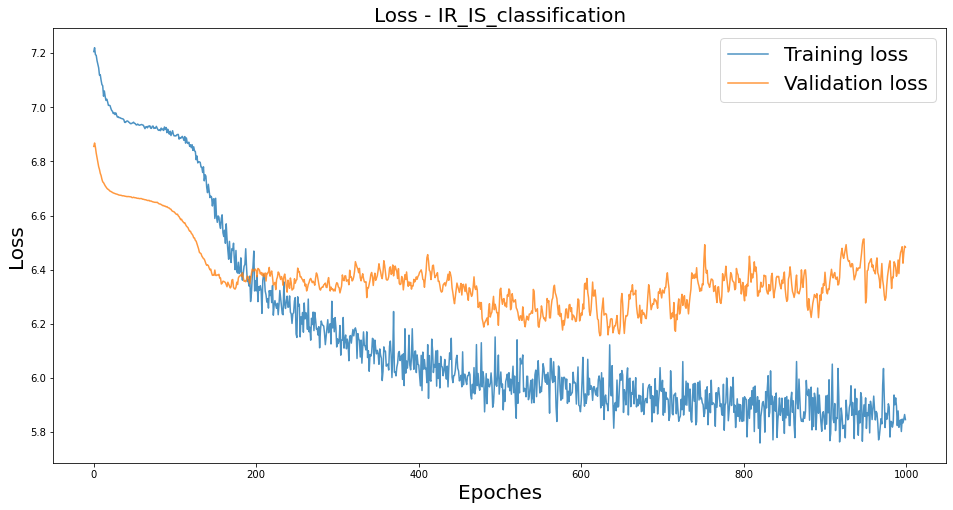

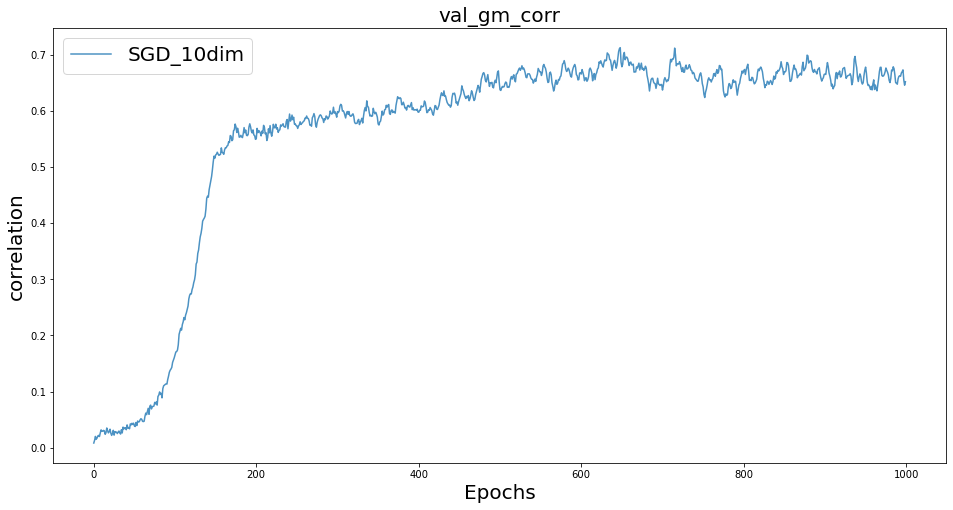

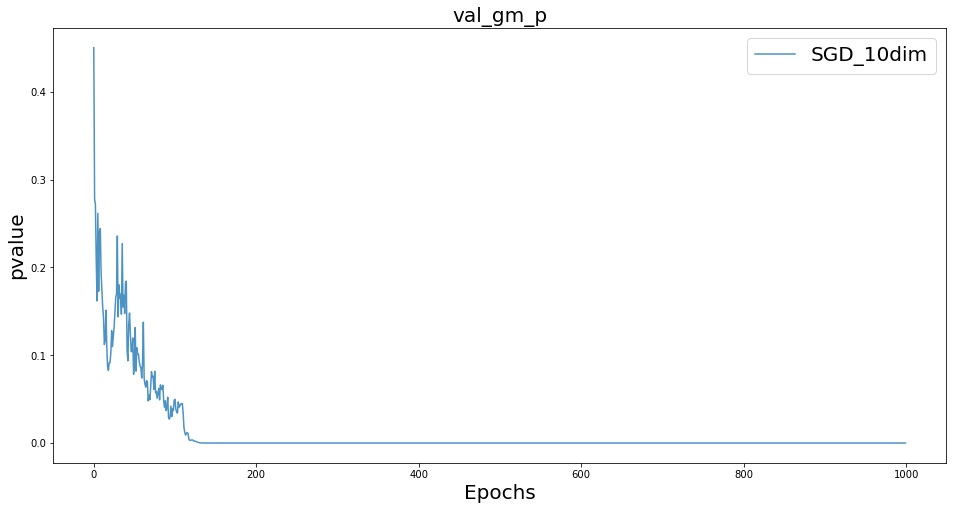

In [16]:
from plotting_utils import plot_loss
from plotting_utils import plot_training

plot_training(covariate='IR_IS_classification', results=results_iris, model_name='MB-SupCon')

In [17]:
### All samples 
store_embedding(index_set_iris[0], 'IR_IS_classification', model_iris, 'all')
### Validation samples only
store_embedding(index_set_iris[2], 'IR_IS_classification', model_iris, 'val')
### Training samples only
store_embedding(index_set_iris[1], 'IR_IS_classification', model_iris, 'train')
### Testing samples only
store_embedding(index_set_iris[3], 'IR_IS_classification', model_iris, 'test')

### 2) Sex

In [18]:
model_sex, optimizer_sex, results_sex, index_set_sex = train_MB_SupCon(covariate='Sex', n_epoch=1000)

n train: 503
n val: 108
n test: 109
Epoch: [0][10/16]	loss 7.153 (7.223)	
	val_loss	6.8478349049886065
Epoch: [1][10/16]	loss 7.214 (7.214)	
	val_loss	6.838543662318477
Epoch: [2][10/16]	loss 7.191 (7.198)	
	val_loss	6.819831989429615
Epoch: [3][10/16]	loss 7.185 (7.189)	
	val_loss	6.797126522770634
Epoch: [4][10/16]	loss 7.171 (7.172)	
	val_loss	6.783054952268247
Epoch: [5][10/16]	loss 7.153 (7.158)	
	val_loss	6.770101600223118
Epoch: [6][10/16]	loss 7.112 (7.130)	
	val_loss	6.758613851335314
Epoch: [7][10/16]	loss 7.084 (7.102)	
	val_loss	6.748152803491663
Epoch: [8][10/16]	loss 7.101 (7.090)	
	val_loss	6.740109443664551
Epoch: [9][10/16]	loss 7.045 (7.056)	
	val_loss	6.735397056297019
Epoch: [10][10/16]	loss 7.053 (7.060)	
	val_loss	6.731019638202809
Epoch: [11][10/16]	loss 7.038 (7.043)	
	val_loss	6.727774302164714
Epoch: [12][10/16]	loss 7.025 (7.048)	
	val_loss	6.7228973529956955
Epoch: [13][10/16]	loss 7.000 (7.015)	
	val_loss	6.721275647481282
Epoch: [14][10/16]	loss 6.994 (7.0

Epoch: [122][10/16]	loss 6.751 (6.818)	
	val_loss	6.605273511674669
Epoch: [123][10/16]	loss 6.881 (6.828)	
	val_loss	6.602497242115162
Epoch: [124][10/16]	loss 6.804 (6.837)	
	val_loss	6.6000662379794655
Epoch: [125][10/16]	loss 6.933 (6.846)	
	val_loss	6.598155357219555
Epoch: [126][10/16]	loss 6.903 (6.805)	
	val_loss	6.598244737695764
Epoch: [127][10/16]	loss 6.741 (6.819)	
	val_loss	6.591279277095088
Epoch: [128][10/16]	loss 6.830 (6.823)	
	val_loss	6.5973962677849665
Epoch: [129][10/16]	loss 6.842 (6.789)	
	val_loss	6.591100092287417
Epoch: [130][10/16]	loss 6.800 (6.781)	
	val_loss	6.589720602388735
Epoch: [131][10/16]	loss 6.840 (6.796)	
	val_loss	6.5923702098705155
Epoch: [132][10/16]	loss 6.773 (6.743)	
	val_loss	6.589961723045066
Epoch: [133][10/16]	loss 6.730 (6.756)	
	val_loss	6.58442642070629
Epoch: [134][10/16]	loss 6.704 (6.749)	
	val_loss	6.581277229167797
Epoch: [135][10/16]	loss 6.598 (6.766)	
	val_loss	6.582752916547987
Epoch: [136][10/16]	loss 6.694 (6.745)	
	val_l

	val_loss	6.5925603266115544
Epoch: [243][10/16]	loss 6.372 (6.390)	
	val_loss	6.568013544435854
Epoch: [244][10/16]	loss 6.351 (6.398)	
	val_loss	6.561769520794904
Epoch: [245][10/16]	loss 6.219 (6.321)	
	val_loss	6.564805560641819
Epoch: [246][10/16]	loss 6.230 (6.343)	
	val_loss	6.5604434189973055
Epoch: [247][10/16]	loss 6.268 (6.383)	
	val_loss	6.549086853309914
Epoch: [248][10/16]	loss 6.402 (6.412)	
	val_loss	6.535878552330865
Epoch: [249][10/16]	loss 6.697 (6.395)	
	val_loss	6.554289182027181
Epoch: [250][10/16]	loss 6.245 (6.295)	
	val_loss	6.573128152776648
Epoch: [251][10/16]	loss 6.011 (6.342)	
	val_loss	6.597976967140481
Epoch: [252][10/16]	loss 6.274 (6.363)	
	val_loss	6.592430291352449
Epoch: [253][10/16]	loss 6.308 (6.395)	
	val_loss	6.580898956016258
Epoch: [254][10/16]	loss 6.683 (6.366)	
	val_loss	6.538885098916513
Epoch: [255][10/16]	loss 6.662 (6.335)	
	val_loss	6.54610068709762
Epoch: [256][10/16]	loss 6.431 (6.322)	
	val_loss	6.549109759154143
Epoch: [257][10/16]

Epoch: [363][10/16]	loss 6.236 (6.119)	
	val_loss	6.558847974847864
Epoch: [364][10/16]	loss 6.457 (6.265)	
	val_loss	6.561847633785671
Epoch: [365][10/16]	loss 6.204 (6.178)	
	val_loss	6.634698002426712
Epoch: [366][10/16]	loss 6.155 (6.278)	
	val_loss	6.622079213460286
Epoch: [367][10/16]	loss 6.121 (6.144)	
	val_loss	6.615690937748662
Epoch: [368][10/16]	loss 6.268 (6.156)	
	val_loss	6.575873763472946
Epoch: [369][10/16]	loss 6.391 (6.212)	
	val_loss	6.627202298906115
Epoch: [370][10/16]	loss 6.175 (6.196)	
	val_loss	6.603212550834373
Epoch: [371][10/16]	loss 6.281 (6.210)	
	val_loss	6.579096599861428
Epoch: [372][10/16]	loss 6.332 (6.245)	
	val_loss	6.587572345027217
Epoch: [373][10/16]	loss 6.074 (6.215)	
	val_loss	6.584880122432002
Epoch: [374][10/16]	loss 6.000 (6.271)	
	val_loss	6.591988528216326
Epoch: [375][10/16]	loss 5.978 (6.243)	
	val_loss	6.5536819563971624
Epoch: [376][10/16]	loss 6.320 (6.251)	
	val_loss	6.550892176451506
Epoch: [377][10/16]	loss 6.101 (6.217)	
	val_lo

	val_loss	6.556416546856916
Epoch: [484][10/16]	loss 5.913 (6.047)	
	val_loss	6.53759585486518
Epoch: [485][10/16]	loss 6.047 (6.049)	
	val_loss	6.541235005414045
Epoch: [486][10/16]	loss 6.368 (6.137)	
	val_loss	6.562221686045329
Epoch: [487][10/16]	loss 6.677 (6.195)	
	val_loss	6.499800629085964
Epoch: [488][10/16]	loss 5.808 (6.121)	
	val_loss	6.471746709611681
Epoch: [489][10/16]	loss 5.978 (6.216)	
	val_loss	6.548683343110262
Epoch: [490][10/16]	loss 6.328 (6.097)	
	val_loss	6.553303347693549
Epoch: [491][10/16]	loss 5.894 (6.234)	
	val_loss	6.49941599810565
Epoch: [492][10/16]	loss 6.313 (6.131)	
	val_loss	6.5488320456610785
Epoch: [493][10/16]	loss 6.121 (6.106)	
	val_loss	6.614984247419569
Epoch: [494][10/16]	loss 5.982 (6.121)	
	val_loss	6.60275865484167
Epoch: [495][10/16]	loss 6.021 (6.075)	
	val_loss	6.516984515719944
Epoch: [496][10/16]	loss 6.326 (6.081)	
	val_loss	6.550742820457176
Epoch: [497][10/16]	loss 6.051 (6.153)	
	val_loss	6.559785101148817
Epoch: [498][10/16]	lo

	val_loss	6.633155328256112
Epoch: [605][10/16]	loss 6.014 (6.046)	
	val_loss	6.580996124832718
Epoch: [606][10/16]	loss 6.436 (6.094)	
	val_loss	6.545604564525463
Epoch: [607][10/16]	loss 5.850 (6.056)	
	val_loss	6.565803987008554
Epoch: [608][10/16]	loss 5.987 (6.054)	
	val_loss	6.676071219974094
Epoch: [609][10/16]	loss 5.921 (5.921)	
	val_loss	6.515996950644034
Epoch: [610][10/16]	loss 6.445 (6.087)	
	val_loss	6.514731424826163
Epoch: [611][10/16]	loss 6.236 (6.044)	
	val_loss	6.481481940658004
Epoch: [612][10/16]	loss 6.281 (6.077)	
	val_loss	6.463653211240415
Epoch: [613][10/16]	loss 5.961 (6.004)	
	val_loss	6.488291316562229
Epoch: [614][10/16]	loss 6.364 (6.117)	
	val_loss	6.590978198581272
Epoch: [615][10/16]	loss 6.144 (6.125)	
	val_loss	6.4113602814850985
Epoch: [616][10/16]	loss 6.157 (6.097)	
	val_loss	6.458000289069282
Epoch: [617][10/16]	loss 6.222 (6.100)	
	val_loss	6.426508868182147
Epoch: [618][10/16]	loss 6.380 (6.025)	
	val_loss	6.4576925878171565
Epoch: [619][10/16

Epoch: [725][10/16]	loss 5.837 (6.015)	
	val_loss	6.489921675788032
Epoch: [726][10/16]	loss 5.828 (6.102)	
	val_loss	6.464124502959074
Epoch: [727][10/16]	loss 6.078 (6.041)	
	val_loss	6.479877648530183
Epoch: [728][10/16]	loss 6.002 (5.872)	
	val_loss	6.5801548074792935
Epoch: [729][10/16]	loss 5.649 (5.951)	
	val_loss	6.645992084785744
Epoch: [730][10/16]	loss 6.254 (5.942)	
	val_loss	6.525597113150138
Epoch: [731][10/16]	loss 6.198 (5.949)	
	val_loss	6.644820266299778
Epoch: [732][10/16]	loss 5.955 (5.931)	
	val_loss	6.537954436408149
Epoch: [733][10/16]	loss 6.062 (6.032)	
	val_loss	6.448232562453659
Epoch: [734][10/16]	loss 6.296 (6.050)	
	val_loss	6.477551672193739
Epoch: [735][10/16]	loss 6.486 (6.134)	
	val_loss	6.564973336678964
Epoch: [736][10/16]	loss 5.813 (5.954)	
	val_loss	6.554991828070746
Epoch: [737][10/16]	loss 5.932 (5.950)	
	val_loss	6.567032319528085
Epoch: [738][10/16]	loss 6.368 (6.015)	
	val_loss	6.495760246559426
Epoch: [739][10/16]	loss 5.945 (6.041)	
	val_lo

	val_loss	6.683265580071343
Epoch: [846][10/16]	loss 5.759 (5.922)	
	val_loss	6.601021625377514
Epoch: [847][10/16]	loss 5.972 (6.131)	
	val_loss	6.5475721889072
Epoch: [848][10/16]	loss 5.985 (5.953)	
	val_loss	6.609223365783691
Epoch: [849][10/16]	loss 6.479 (6.050)	
	val_loss	6.5135617079558195
Epoch: [850][10/16]	loss 5.705 (5.997)	
	val_loss	6.451396765532317
Epoch: [851][10/16]	loss 6.085 (5.992)	
	val_loss	6.580436706542969
Epoch: [852][10/16]	loss 6.028 (5.982)	
	val_loss	6.501774752581561
Epoch: [853][10/16]	loss 5.904 (6.056)	
	val_loss	6.459831096507885
Epoch: [854][10/16]	loss 5.866 (5.949)	
	val_loss	6.481467953434697
Epoch: [855][10/16]	loss 5.681 (5.959)	
	val_loss	6.551461961534288
Epoch: [856][10/16]	loss 5.776 (5.988)	
	val_loss	6.637729114956326
Epoch: [857][10/16]	loss 6.083 (5.982)	
	val_loss	6.636966352109556
Epoch: [858][10/16]	loss 5.991 (6.042)	
	val_loss	6.563479017328333
Epoch: [859][10/16]	loss 6.013 (6.083)	
	val_loss	6.505364523993598
Epoch: [860][10/16]	l

	val_loss	6.738310407709192
Epoch: [967][10/16]	loss 6.449 (5.924)	
	val_loss	6.713794372699879
Epoch: [968][10/16]	loss 5.728 (5.921)	
	val_loss	6.683938379640932
Epoch: [969][10/16]	loss 5.911 (5.922)	
	val_loss	6.725070741441515
Epoch: [970][10/16]	loss 5.733 (5.965)	
	val_loss	6.728908609460901
Epoch: [971][10/16]	loss 5.836 (6.008)	
	val_loss	6.607178264194065
Epoch: [972][10/16]	loss 6.042 (5.933)	
	val_loss	6.73162477987784
Epoch: [973][10/16]	loss 5.747 (6.034)	
	val_loss	6.630490091111925
Epoch: [974][10/16]	loss 5.733 (5.949)	
	val_loss	6.638889983848289
Epoch: [975][10/16]	loss 5.666 (6.019)	
	val_loss	6.6334496957284435
Epoch: [976][10/16]	loss 6.217 (5.902)	
	val_loss	6.599322619261565
Epoch: [977][10/16]	loss 5.854 (5.939)	
	val_loss	6.6679752491138595
Epoch: [978][10/16]	loss 5.869 (5.979)	
	val_loss	6.612638968008536
Epoch: [979][10/16]	loss 6.091 (5.978)	
	val_loss	6.616105326899776
Epoch: [980][10/16]	loss 5.835 (6.021)	
	val_loss	6.498335908960413
Epoch: [981][10/16]

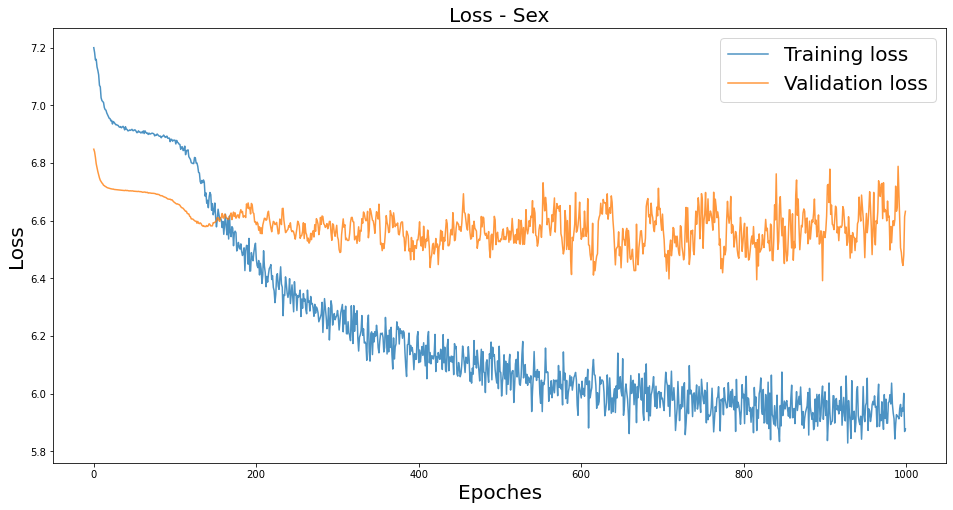

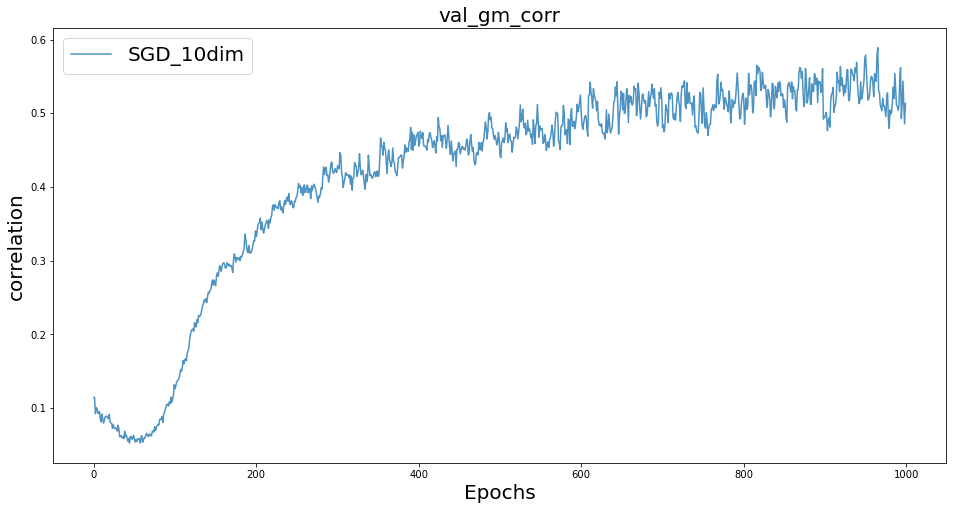

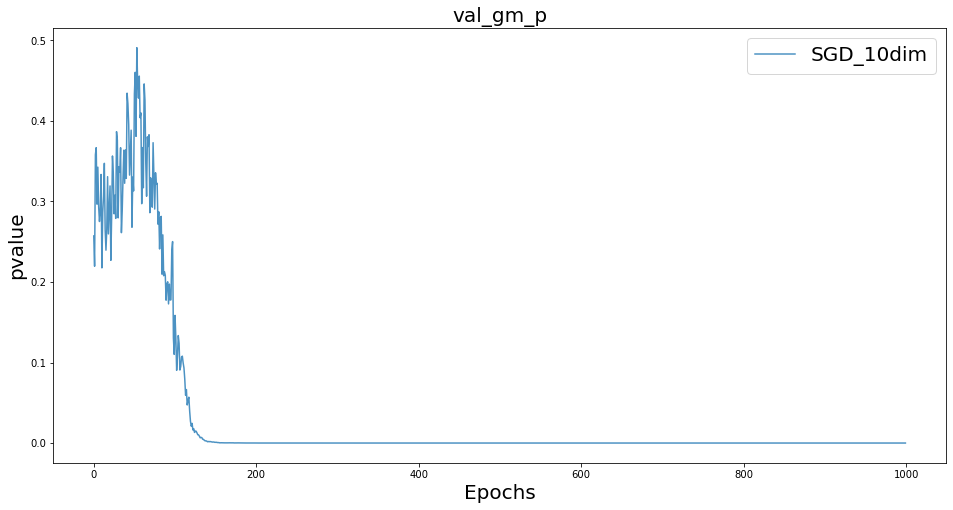

In [19]:
plot_training(covariate='Sex', results=results_sex, model_name='MB-SupCon')

In [20]:
### All samples 
store_embedding(index_set_sex[0], 'Sex', model_sex, 'all')
### Validation samples only
store_embedding(index_set_sex[2], 'Sex', model_sex, 'val')
### Training samples only
store_embedding(index_set_sex[1], 'Sex', model_sex, 'train')
### Testing samples only
store_embedding(index_set_sex[3], 'Sex', model_sex, 'test')

### 3) Race

In [21]:
model_race, optimizer_race, results_race, index_set_race = train_MB_SupCon(covariate='Race', n_epoch=1000)

n train: 502
n val: 107
n test: 109
Epoch: [0][10/16]	loss 7.331 (7.208)	
	val_loss	6.881382434167595
Epoch: [1][10/16]	loss 7.158 (7.182)	
	val_loss	6.868213903124087
Epoch: [2][10/16]	loss 7.172 (7.172)	
	val_loss	6.845669728573237
Epoch: [3][10/16]	loss 7.244 (7.158)	
	val_loss	6.8211869836967685
Epoch: [4][10/16]	loss 7.057 (7.096)	
	val_loss	6.8052364242411105
Epoch: [5][10/16]	loss 7.068 (7.076)	
	val_loss	6.79210171298446
Epoch: [6][10/16]	loss 7.015 (7.051)	
	val_loss	6.775632956317652
Epoch: [7][10/16]	loss 7.036 (7.031)	
	val_loss	6.764040608272374
Epoch: [8][10/16]	loss 7.082 (7.032)	
	val_loss	6.753409506004547
Epoch: [9][10/16]	loss 7.045 (7.010)	
	val_loss	6.746359210148036
Epoch: [10][10/16]	loss 7.048 (7.011)	
	val_loss	6.740528249294958
Epoch: [11][10/16]	loss 6.982 (6.991)	
	val_loss	6.734377116800468
Epoch: [12][10/16]	loss 7.040 (6.992)	
	val_loss	6.7291998105628466
Epoch: [13][10/16]	loss 6.937 (6.983)	
	val_loss	6.728623399110598
Epoch: [14][10/16]	loss 6.991 (6.9

	val_loss	6.412011173283942
Epoch: [122][10/16]	loss 6.453 (6.275)	
	val_loss	6.385997117122757
Epoch: [123][10/16]	loss 6.502 (6.388)	
	val_loss	6.359875028378496
Epoch: [124][10/16]	loss 6.471 (6.321)	
	val_loss	6.389606689738336
Epoch: [125][10/16]	loss 6.205 (6.202)	
	val_loss	6.3966857963633315
Epoch: [126][10/16]	loss 6.446 (6.227)	
	val_loss	6.405573292313335
Epoch: [127][10/16]	loss 6.029 (6.257)	
	val_loss	6.396837657857164
Epoch: [128][10/16]	loss 6.315 (6.267)	
	val_loss	6.437879499988021
Epoch: [129][10/16]	loss 5.868 (6.302)	
	val_loss	6.39483957201521
Epoch: [130][10/16]	loss 6.488 (6.303)	
	val_loss	6.385027092193889
Epoch: [131][10/16]	loss 5.958 (6.228)	
	val_loss	6.395831277437299
Epoch: [132][10/16]	loss 6.047 (6.328)	
	val_loss	6.3892593294660625
Epoch: [133][10/16]	loss 6.206 (6.255)	
	val_loss	6.391901934258292
Epoch: [134][10/16]	loss 6.252 (6.217)	
	val_loss	6.416241039739591
Epoch: [135][10/16]	loss 6.103 (6.213)	
	val_loss	6.421893146550544
Epoch: [136][10/16]

	val_loss	6.3701295050505164
Epoch: [243][10/16]	loss 6.213 (5.986)	
	val_loss	6.3378491713621905
Epoch: [244][10/16]	loss 5.927 (5.979)	
	val_loss	6.312932829990565
Epoch: [245][10/16]	loss 6.275 (5.982)	
	val_loss	6.374317868847713
Epoch: [246][10/16]	loss 6.505 (6.012)	
	val_loss	6.371218984372148
Epoch: [247][10/16]	loss 5.923 (5.940)	
	val_loss	6.38564395904541
Epoch: [248][10/16]	loss 6.080 (5.973)	
	val_loss	6.385976492801559
Epoch: [249][10/16]	loss 6.182 (5.944)	
	val_loss	6.3433586147344
Epoch: [250][10/16]	loss 6.073 (5.899)	
	val_loss	6.3555081536836715
Epoch: [251][10/16]	loss 5.866 (5.946)	
	val_loss	6.351938318983417
Epoch: [252][10/16]	loss 5.807 (6.027)	
	val_loss	6.338020592092354
Epoch: [253][10/16]	loss 6.109 (5.987)	
	val_loss	6.339111252365825
Epoch: [254][10/16]	loss 7.096 (6.066)	
	val_loss	6.3555225033626375
Epoch: [255][10/16]	loss 6.595 (6.016)	
	val_loss	6.371463508249443
Epoch: [256][10/16]	loss 6.048 (5.948)	
	val_loss	6.343040600001255
Epoch: [257][10/16]

	val_loss	6.321069476760436
Epoch: [364][10/16]	loss 5.578 (5.908)	
	val_loss	6.263514973292841
Epoch: [365][10/16]	loss 5.928 (5.849)	
	val_loss	6.262932037638727
Epoch: [366][10/16]	loss 5.824 (5.972)	
	val_loss	6.260683269144218
Epoch: [367][10/16]	loss 6.020 (5.887)	
	val_loss	6.231934395905967
Epoch: [368][10/16]	loss 6.261 (5.877)	
	val_loss	6.25056338978705
Epoch: [369][10/16]	loss 6.012 (5.902)	
	val_loss	6.2941667788496645
Epoch: [370][10/16]	loss 6.019 (5.868)	
	val_loss	6.2707469441066275
Epoch: [371][10/16]	loss 5.794 (5.948)	
	val_loss	6.280229470440161
Epoch: [372][10/16]	loss 5.496 (5.882)	
	val_loss	6.328388797902615
Epoch: [373][10/16]	loss 5.804 (5.909)	
	val_loss	6.323322808631112
Epoch: [374][10/16]	loss 5.653 (5.810)	
	val_loss	6.36879961067271
Epoch: [375][10/16]	loss 6.388 (5.973)	
	val_loss	6.376368549382575
Epoch: [376][10/16]	loss 5.693 (5.873)	
	val_loss	6.274087192856263
Epoch: [377][10/16]	loss 5.879 (5.853)	
	val_loss	6.276937391156348
Epoch: [378][10/16]	

	val_loss	6.428345261333145
Epoch: [485][10/16]	loss 6.136 (5.831)	
	val_loss	6.501671229567483
Epoch: [486][10/16]	loss 5.840 (5.704)	
	val_loss	6.466787159999955
Epoch: [487][10/16]	loss 6.278 (5.883)	
	val_loss	6.385391449259821
Epoch: [488][10/16]	loss 5.787 (5.749)	
	val_loss	6.364838644722912
Epoch: [489][10/16]	loss 6.235 (5.858)	
	val_loss	6.431042965327467
Epoch: [490][10/16]	loss 5.848 (5.730)	
	val_loss	6.432343162108805
Epoch: [491][10/16]	loss 5.773 (5.903)	
	val_loss	6.4105134634214025
Epoch: [492][10/16]	loss 6.114 (5.951)	
	val_loss	6.427912150587991
Epoch: [493][10/16]	loss 5.652 (5.829)	
	val_loss	6.4390333122182115
Epoch: [494][10/16]	loss 5.455 (5.934)	
	val_loss	6.477860000646003
Epoch: [495][10/16]	loss 5.624 (5.865)	
	val_loss	6.4333501530584885
Epoch: [496][10/16]	loss 5.680 (5.765)	
	val_loss	6.431333189812776
Epoch: [497][10/16]	loss 5.515 (5.792)	
	val_loss	6.449380803331036
Epoch: [498][10/16]	loss 6.151 (5.867)	
	val_loss	6.467303262692746
Epoch: [499][10/1

	val_loss	6.472753734232109
Epoch: [606][10/16]	loss 5.400 (5.697)	
	val_loss	6.365712134637565
Epoch: [607][10/16]	loss 5.579 (5.664)	
	val_loss	6.351708982592431
Epoch: [608][10/16]	loss 6.179 (5.810)	
	val_loss	6.417434460648867
Epoch: [609][10/16]	loss 5.631 (5.757)	
	val_loss	6.346210711470274
Epoch: [610][10/16]	loss 5.513 (5.862)	
	val_loss	6.309568405151367
Epoch: [611][10/16]	loss 5.980 (5.756)	
	val_loss	6.314827638251759
Epoch: [612][10/16]	loss 5.283 (5.613)	
	val_loss	6.388820790798865
Epoch: [613][10/16]	loss 5.659 (5.787)	
	val_loss	6.267354617609042
Epoch: [614][10/16]	loss 6.296 (5.831)	
	val_loss	6.272565208862875
Epoch: [615][10/16]	loss 5.742 (5.771)	
	val_loss	6.294817554616483
Epoch: [616][10/16]	loss 5.990 (5.756)	
	val_loss	6.267318632001075
Epoch: [617][10/16]	loss 5.528 (5.634)	
	val_loss	6.338957813298591
Epoch: [618][10/16]	loss 5.724 (5.712)	
	val_loss	6.329984843173873
Epoch: [619][10/16]	loss 5.562 (5.736)	
	val_loss	6.337206983120642
Epoch: [620][10/16]	

	val_loss	6.424526397312913
Epoch: [727][10/16]	loss 6.316 (5.809)	
	val_loss	6.492489627588575
Epoch: [728][10/16]	loss 5.805 (5.810)	
	val_loss	6.449209284559589
Epoch: [729][10/16]	loss 5.832 (5.743)	
	val_loss	6.406428399487076
Epoch: [730][10/16]	loss 5.724 (5.710)	
	val_loss	6.387675909238441
Epoch: [731][10/16]	loss 5.775 (5.755)	
	val_loss	6.501015885968075
Epoch: [732][10/16]	loss 5.338 (5.700)	
	val_loss	6.4654416369500565
Epoch: [733][10/16]	loss 5.533 (5.756)	
	val_loss	6.48837947845459
Epoch: [734][10/16]	loss 6.184 (5.730)	
	val_loss	6.427204345988336
Epoch: [735][10/16]	loss 5.541 (5.819)	
	val_loss	6.450116540784034
Epoch: [736][10/16]	loss 5.967 (5.680)	
	val_loss	6.6526113492306145
Epoch: [737][10/16]	loss 5.261 (5.929)	
	val_loss	6.493041346006304
Epoch: [738][10/16]	loss 5.656 (5.680)	
	val_loss	6.422865729465663
Epoch: [739][10/16]	loss 5.891 (5.721)	
	val_loss	6.519952622529503
Epoch: [740][10/16]	loss 5.428 (5.681)	
	val_loss	6.544053095523442
Epoch: [741][10/16]

	val_loss	6.5176348953603584
Epoch: [848][10/16]	loss 6.478 (5.872)	
	val_loss	6.435114076204389
Epoch: [849][10/16]	loss 5.219 (5.790)	
	val_loss	6.450227594821253
Epoch: [850][10/16]	loss 6.071 (5.752)	
	val_loss	6.48453382688148
Epoch: [851][10/16]	loss 5.445 (5.744)	
	val_loss	6.4974568135270445
Epoch: [852][10/16]	loss 5.708 (5.685)	
	val_loss	6.502894410463137
Epoch: [853][10/16]	loss 6.293 (5.816)	
	val_loss	6.472845451854099
Epoch: [854][10/16]	loss 5.551 (5.684)	
	val_loss	6.423172683359306
Epoch: [855][10/16]	loss 5.552 (5.658)	
	val_loss	6.38710943560734
Epoch: [856][10/16]	loss 6.012 (5.793)	
	val_loss	6.266402503040349
Epoch: [857][10/16]	loss 5.744 (5.747)	
	val_loss	6.294114897184283
Epoch: [858][10/16]	loss 5.564 (5.705)	
	val_loss	6.281711302070974
Epoch: [859][10/16]	loss 5.657 (5.663)	
	val_loss	6.348234613365102
Epoch: [860][10/16]	loss 5.675 (5.577)	
	val_loss	6.3646696170913835
Epoch: [861][10/16]	loss 5.488 (5.628)	
	val_loss	6.328682672197574
Epoch: [862][10/16]

	val_loss	6.356576135225385
Epoch: [969][10/16]	loss 5.980 (5.706)	
	val_loss	6.283338457624489
Epoch: [970][10/16]	loss 5.500 (5.657)	
	val_loss	6.268699151333247
Epoch: [971][10/16]	loss 5.895 (5.643)	
	val_loss	6.309851913808663
Epoch: [972][10/16]	loss 5.590 (5.723)	
	val_loss	6.277780497185538
Epoch: [973][10/16]	loss 5.747 (5.670)	
	val_loss	6.299339784640018
Epoch: [974][10/16]	loss 5.517 (5.655)	
	val_loss	6.277120073265005
Epoch: [975][10/16]	loss 5.500 (5.819)	
	val_loss	6.287896557389018
Epoch: [976][10/16]	loss 5.423 (5.684)	
	val_loss	6.261192054392021
Epoch: [977][10/16]	loss 5.516 (5.632)	
	val_loss	6.301188665015675
Epoch: [978][10/16]	loss 6.235 (5.656)	
	val_loss	6.302083095657491
Epoch: [979][10/16]	loss 5.670 (5.684)	
	val_loss	6.294023585096698
Epoch: [980][10/16]	loss 5.461 (5.678)	
	val_loss	6.285539809788499
Epoch: [981][10/16]	loss 5.749 (5.801)	
	val_loss	6.32110184821013
Epoch: [982][10/16]	loss 5.896 (5.658)	
	val_loss	6.348016106079672
Epoch: [983][10/16]	l

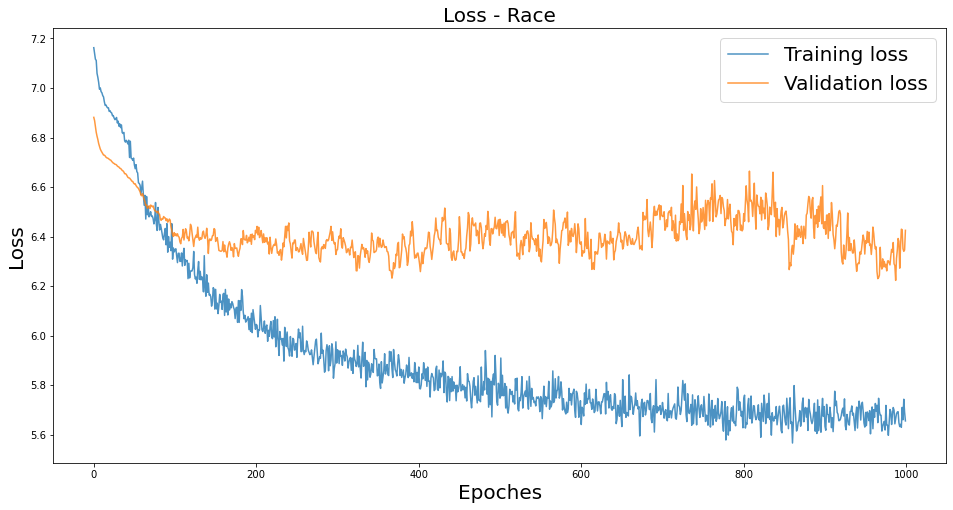

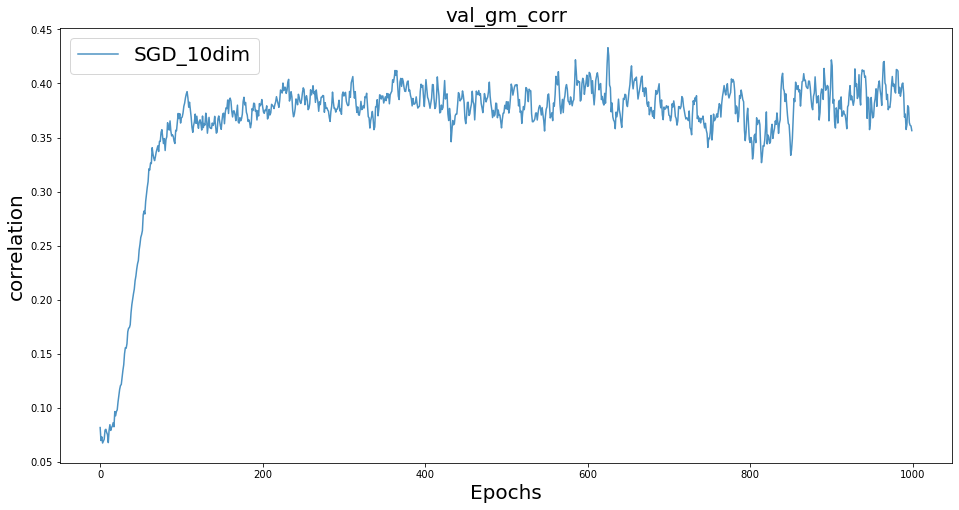

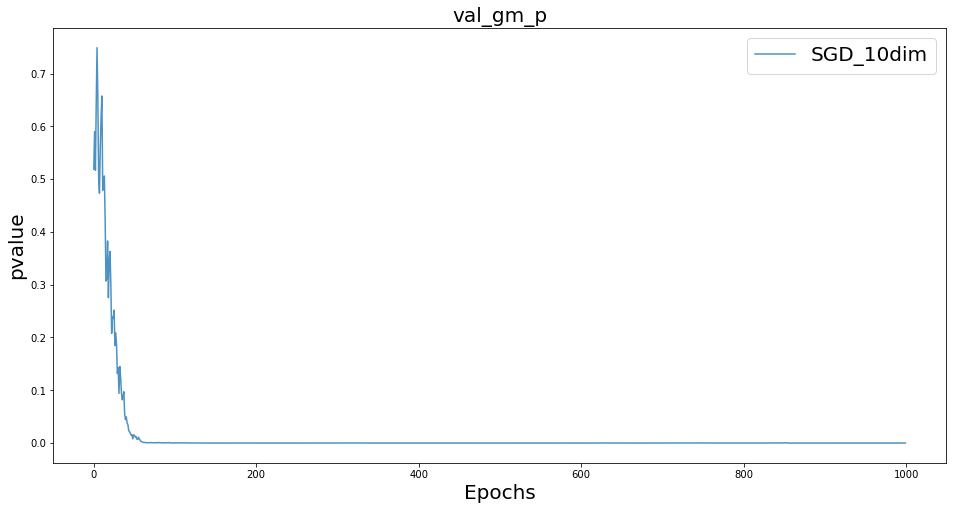

In [22]:
plot_training(covariate='Race', results=results_race, model_name='MB-SupCon')

In [23]:
### All samples 
store_embedding(index_set_race[0], 'Race', model_race, 'all')
### Validation samples only
store_embedding(index_set_race[2], 'Race', model_race, 'val')
### Training samples only
store_embedding(index_set_race[1], 'Race', model_race, 'train')
### Testing samples only
store_embedding(index_set_race[3], 'Race', model_race, 'test')

In [43]:
!pip freeze

alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-client==1.7.2
anaconda-navigator==2.0.3
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1610472525955/work
anyio @ file:///tmp/build/80754af9/anyio_1617783275907/work/dist
appdirs==1.4.4
argh==0.26.2
argon2-cffi @ file:///tmp/build/80754af9/argon2-cffi_1613037097816/work
asn1crypto @ file:///tmp/build/80754af9/asn1crypto_1596577642040/work
astroid @ file:///tmp/build/80754af9/astroid_1613500854201/work
astropy @ file:///tmp/build/80754af9/astropy_1617745353437/work
async-generator @ file:///home/ktietz/src/ci/async_generator_1611927993394/work
atomicwrites==1.4.0
attrs @ file:///tmp/build/80754af9/attrs_1604765588209/work
autopep8 @ file:///tmp/build/80754af9/autopep8_1615918855173/work
Babel @ file:///tmp/build/80754af9/babel_1607110387436/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
backports.functools-lru-cache @ file:///home/conda/feedstock_root/build_artifacts/back